--------------------------------------------
**All information in ths notebook is licensed under the BSD 3-Clause "New" or "Revised" License. The license is found [here](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/LICENSE).**

**If any part of this notebook is used in your research, please cite with the reference found in [README.md](https://github.com/jGaboardi/non-duplicated-intersects/blob/master/README.md#bibtex-citation).**

--------------------------------------------
# Non-duplicated intersects 
## Demonstrating an enhanced intersect operation with [sjoin in GeoPandas](http://geopandas.org/reference/geopandas.sjoin.html)
### Author: James D. Gaboardi jgaboardi@gmail.com
-----------------------------------
**This notebook demonstrates the strengths of combining the concepts of `within` and `intersects` for a non-duplicated `intersects` version of spatial join. This method can be thought of as "point-associated-with-polygon," because it captures the spatial relationship of points contained within a polygon and touching the exterior of the polygon, while preserving the cardinality of the original point set, $|P| = |P^\prime|$.**

### Overview

1. **Defined variables**
2. **Generating synthetic data**
3. **Demonstrating `within`**
4. **Demonstrating `intersects`**
5. **Demonstrating non-duplicated `intersects` (`nd-intersects`)**

In [1]:
%load_ext watermark
%watermark

2020-01-29T21:08:59-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import nd_intersects

# import for watermark
import geopandas
import matplotlib
import shapely

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina", quality=100)
except ImportError:
    pass

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
matplotlib    3.1.2
nd_intersects 0.0.1
geopandas     0.6.2
shapely       1.6.4.post2



---------------------------------------
## 1. Defined Variables

In [3]:
ptid = "point_id"
pgid = "polygon_id"
columns = [ptid, pgid]
within = "within"
intersects = "intersects"

----------------------------------------
## 2. Synthetic Data
### Synthetic points

In [4]:
points = nd_intersects.demo_points(ptid)
n_points = points.shape[0]
points

,point_id,geometry
0,A,POINT (-1.00000 -1.00000)
1,B,POINT (0.00000 -1.00000)
2,C,POINT (0.50000 -0.75000)
3,D,POINT (-0.50000 -0.50000)
4,E,POINT (0.50000 -0.50000)
5,F,POINT (0.00000 0.00000)
6,G,POINT (0.50000 0.50000)


### Synthetic polygons

In [5]:
polygons = nd_intersects.demo_polygons(pgid)
polygons

,polygon_id,geometry
0,x,"POLYGON ((-1.00000 -1.00000, 0.00000 -1.00000,..."
1,y,"POLYGON ((0.00000 -1.00000, 1.00000 -1.00000, ..."
2,z,"POLYGON ((-1.00000 0.00000, 0.00000 0.00000, 0..."


----------------------------------------------------
## 3. Perform left spatial join and plot — `within`
**The issue with a `within` operation is a point that exactly intersects a polygon exterior (`touch`) is not contained in the polygon and, therefore, not included in the spatial join.**

In [6]:
args = [points, polygons, within, ptid, pgid, columns]

In [7]:
%timeit nd_intersects.do_sjoin(*args)

21.2 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
within_df = nd_intersects.do_sjoin(*args)
within_df

,point_id,polygon_id,geometry
0,A,NaN,POINT (-1.00000 -1.00000)
1,B,NaN,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,NaN,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


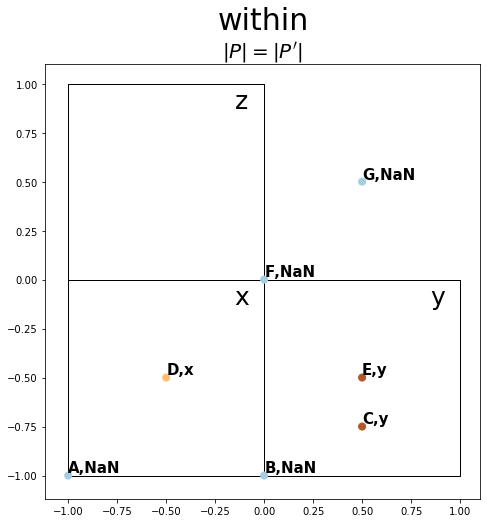

In [9]:
args = [within_df, polygons, ptid, pgid, within, n_points]
nd_intersects.demo_plot_join(*args, save="images/%s"%within)

-------------------------
## 4. Perform left spatial join and plot — `intersects`
**The issue with an `intersects` operation is a point that exactly intersects multiple polygon exteriors (`touch`) is duplicated for each polygon it intersects and, thus, increases the set cardinality.**

In [10]:
args = [points, polygons, intersects, ptid, pgid, columns]

In [11]:
%timeit nd_intersects.do_sjoin(*args)

22.9 ms ± 5.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
intersects_df = nd_intersects.do_sjoin(*args)
intersects_df

,point_id,polygon_id,geometry
0,A,x,POINT (-1.00000 -1.00000)
1,B,x,POINT (0.00000 -1.00000)
1,B,y,POINT (0.00000 -1.00000)
2,C,y,POINT (0.50000 -0.75000)
3,D,x,POINT (-0.50000 -0.50000)
4,E,y,POINT (0.50000 -0.50000)
5,F,x,POINT (0.00000 0.00000)
5,F,y,POINT (0.00000 0.00000)
5,F,z,POINT (0.00000 0.00000)
6,G,NaN,POINT (0.50000 0.50000)


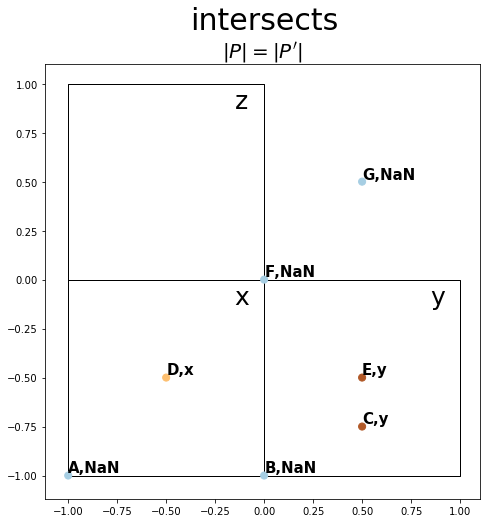

In [13]:
args = [within_df, polygons, ptid, pgid, intersects, n_points]
nd_intersects.demo_plot_join(*args, save="images/%s"%intersects)

-------------------------------------
## 5. Solution: a non-duplicated intersects operation
### This method has two benefits:
* **polygon attribute values are squashed into one label, which can be extracted later; and**
* **the set cardinality of the original dataset is preserved**

In [14]:
args = [points, polygons, ptid, pgid, columns]

In [15]:
%timeit nd_intersects.nd_intersects(*args)

32.4 ms ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
nd_intersects_df = nd_intersects.nd_intersects(*args)
nd_intersects_df

,point_id,polygon_id,geometry
0,A,x,POINT (-1 -1)
1,B,x-y,POINT (0 -1)
2,C,y,POINT (0.5 -0.75)
3,D,x,POINT (-0.5 -0.5)
4,E,y,POINT (0.5 -0.5)
5,F,x-y-z,POINT (0 0)
6,G,NaN,POINT (0.5 0.5)


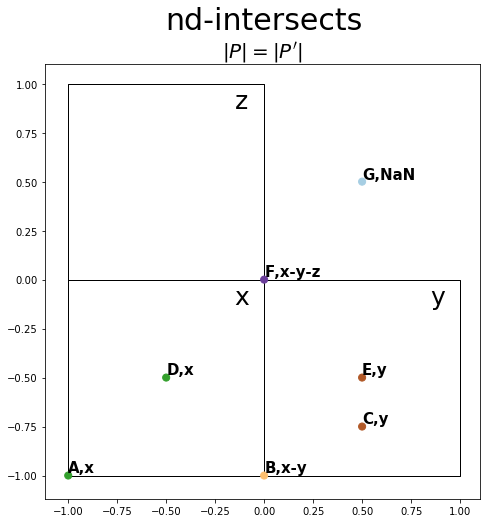

In [17]:
plt_title = "nd-%s" % intersects
args = [nd_intersects_df, polygons, ptid, pgid, plt_title, n_points]
nd_intersects.demo_plot_join(*args, save="images/%s"%plt_title)

------------------